<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introdução-ao-Cenário" data-toc-modified-id="Introdução-ao-Cenário-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introdução ao Cenário</a></span><ul class="toc-item"><li><span><a href="#Pool-de-Ideias" data-toc-modified-id="Pool-de-Ideias-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pool de Ideias</a></span></li><li><span><a href="#Bibliotecas-do-Projeto" data-toc-modified-id="Bibliotecas-do-Projeto-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Bibliotecas do Projeto</a></span></li><li><span><a href="#Variáveis-do-Projeto" data-toc-modified-id="Variáveis-do-Projeto-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Variáveis do Projeto</a></span></li></ul></li><li><span><a href="#Leitura-e-Armazenagem-dos-Audios" data-toc-modified-id="Leitura-e-Armazenagem-dos-Audios-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Leitura e Armazenagem dos Audios</a></span></li><li><span><a href="#Preparação-e-Extração-de-Features" data-toc-modified-id="Preparação-e-Extração-de-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparação e Extração de Features</a></span><ul class="toc-item"><li><span><a href="#Funções-e-Classes-de-Preparação" data-toc-modified-id="Funções-e-Classes-de-Preparação-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Funções e Classes de Preparação</a></span></li><li><span><a href="#Preparação-da-Base" data-toc-modified-id="Preparação-da-Base-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preparação da Base</a></span></li></ul></li><li><span><a href="#Modelagem" data-toc-modified-id="Modelagem-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelagem</a></span><ul class="toc-item"><li><span><a href="#Train,-Dev-e-Teste" data-toc-modified-id="Train,-Dev-e-Teste-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Train, Dev e Teste</a></span></li><li><span><a href="#Definições-Iniciais" data-toc-modified-id="Definições-Iniciais-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Definições Iniciais</a></span></li><li><span><a href="#Treinamento-de-Modelos" data-toc-modified-id="Treinamento-de-Modelos-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Treinamento de Modelos</a></span></li><li><span><a href="#Avaliando-Performance" data-toc-modified-id="Avaliando-Performance-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Avaliando Performance</a></span></li></ul></li></ul></div>

Este notebook é uma continuação direta do documento **Voice Unlocker - Audio Feature Extraction** presente no mesmo diretório do projeto. Seu grande objetivo é propor a consolidação das etapas de modelagem que envolvem a construção de um modelo de Machine Learning capaz de reconhecer locutores a partir de sinais de fala. Para isso, será utilizado um _pipeline_ de preparação de dados construídos no notebook de extração de features referenciado acima, além de sinais de áudio gravados para enriquecimento de uma base única de entrada para a modelagem.

O projeto **Voice Unlocker** refere-se a construção de uma inteligência capaz de reconhecer interlocutores e acionar dispositivos eletrônicos a partir da voz. O desenvolvimento do código e das análises teóricas a seguir faz parte do trabalho de graduação do curso de Engenharia de Informação, oferecido pela Universidade Federal do ABC.

<img src="https://i.imgur.com/Mlc4aW6.png" alt="voice-unlocker logo">

# Introdução ao Cenário

O processo de modelagem aqui exemplificado tem seu início definido após uma rica análise e um completo entendimento sobre sinais de áudio e as principais características extraídas dos mesmos de modo a descreve-los de forma a proporcionar uma análise computacional de qualidade. Assim, entre os resultados mais relevantes obtidos no notebook **Voice Unlocker - Audio Feature Extraction**, é possível considerar o conhecimento adquirido nas _features_ de áudio e também a construção do pipeline `audio_fe_pipeline.pkl` armazenado em `./pipelines/`. Neste pipeline, encontra-se consolidado todo o processamento de preparação e extração de _features_ de sinais de áudio presentes em uma base construída, permitindo assim um total encapsulamento das etapas e a utilização dos transformadores em qualquer documento.

Dessa forma, a etapa de modelagem tem como princípio a leitura de uma base de dados contendo gravações de áudio, a aplicação de um pipeline de preparação responsável pela extração de features e, por fim, a aplicação e validação de algoritmos de Machine Learning para a construção de um modelo eficiente de reconhecimento de locutores. Detalhando a última etapa, é esperado uma análise paralela das principais _features_ de áudio que impactam na resposta do modelo, possibilitando conclusões mais diretas sobre o processo de extração de variáveis.

## Pool de Ideias

`[IDEIA 01]` Utilização do pacote `pycomp` para o treinamento e a avaliação de modelos preditivos, construindo visões e gerando bases analíticas sobre performance e conceitos técnicos de modelagem.

## Bibliotecas do Projeto

In [1]:
import librosa
import librosa.display as ld
import pandas as pd
import numpy as np
import os
import shutil
import time
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from pycomp.ml.trainer import ClassificadorMulticlasse
from pycomp.viz.insights import *

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from warnings import filterwarnings
filterwarnings('ignore')

## Variáveis do Projeto

In [2]:
# Definindo variáveis de diretórios
PROJECT_PATH = '/home/paninit/workspaces/voice-unlocker'
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
AUDIOS_PATH = os.path.join(PROJECT_PATH, 'data/audios')
MCV_PATH = os.path.join(PROJECT_PATH, 'data/mozilla-common-voice/cv-corpus-6.1-2020-12-11/pt')
MCV_TRAIN_PATH = os.path.join(MCV_PATH, 'train.tsv')
MCV_CLIPS_PATH = os.path.join(MCV_PATH, 'clips')
PIPELINES_PATH = os.path.join(PROJECT_PATH, 'pipelines')
PIPELINE_NAME = 'audio_fe_pipeline.pkl'

# Definindo variáveis de processamento de áudios
SAMPLE_RATE = 22050

# Definindo variáveis de referências auxiliares
SIGNAL_COL = 'signal'
TARGET_COL = 'y_class'
ENCODED_TARGET = False
N_CLASSES = 4
TARGET_NAMES = [f'Locutor 0{i}' for i in range(1, N_CLASSES + 1)]

# Definindo variáveis relacionadas a enriquecimento com Mozilla Common Voice
COPY_MCV = False
LABEL_PREFIX = 'interlocutor_'
NEW_FOLDER = False
N_MCV_FILES = 200

# Definindo variáveis relacionadas a separação de datasets (train, val, test)
TRAIN_RATIO = 0.75
VAL_RATIO = 0.15
TEST_RATIO = 0.10

# Definindo variáveis para visualizações gráficas
DONUT_COLORS = ['cadetblue', 'salmon', 'seagreen', 'navy']

# Leitura e Armazenagem dos Audios

Após a definição do dataset inicial a ser utilizado para manusear os sinais de áudio desde a leitura até o possível treinamento de modelos de Machine Learning utilizando features de áudio extraídas durante o processo, é possível realizar uma análise de viabilidade em termos de ler e armazenar os sinais de áudio disponíveis ainda em seu formato de séries temporais.

Para isso, será preciso utilizar algumas variáveis de projeto definidas acima para apontar a busca de arquivos em um diretório alvo. Utilizando a biblioteca `os`, mais especificamente seu método `os.walk()`, será possível retornar algumas informações relevantes a respeito de arquivos armazenados em um diretório alvo. Com isso, será possível utilizar a biblioteca `librosa` para utilizar essas referências retornadas e ler os sinais de áudio disponibilizados neste diretório alvo.

Um outro fator importante a ser considerado nessa etapa de leitura é o enriquecimento da base de dados com áudios relacionados a classe vinculada ao interlocutor $N-1$. Em outras palavras, é importante, em termos de modelagem, considerar uma classe genérica inerente aos interlocutores alvos da predição. Dessa forma, foi considerado o contéudo contido na base de dados _Mozilla Common Voice_ como forma de enriquecer a base oficial do projeto com áudios genéricos extraídos do portal e gravados por diferentes pessoas. Assim, as funções `copy_common_voice()` e `read_data()`, definidas abaixo, tem por objetivo copiar dados baixados do pacote genérico Mozilla Common Voice e ler os áudios contidos no diretório destino do projeto, gerando assim uma base oficial com as informações necessárias para tratamentos futuros.

In [3]:
# Definindo função para cópia de arquivos de áudio do portal Mozilla Common Voice
def copy_common_voice(mcv_train_path, mcv_clips_path, data_path, n_mcv_files=10, 
                      label_prefix='interlocutor_', new_folder=False):
    """
    Função responsável por copiar arquivos de áudio do diretório local Mozilla Common Voice
    
    Parâmetros
    ----------
    :param mcv_train_path: referência de arquivo train.tsv do Mozilla Common Voice [type: string]
    :param mcv_clips_path: diretório contendo áudios do Mozilla Common Voice [type: string]
    :param data_path: diretório de dados do projeto Voice Unlocker [type: string]
    :param n_mcv_files: quantidade de arquivos mp3 a serem copiados do MCV [type: int, default=10]
    :param label_prefix: prefixo de label no diretório do Voice Unlcoker [type: string, default='interlocutor_']
    :param new_folder: flag para criação de nova pasta de interlocutor [type: bool, default=False]
    
    Retorno
    -------
    Essa função não retorna nenhum parâmetro além da devida cópia dos arquivos do diretório
    Mozilla Common Voice para o diretório do projeto Voice Unlocker na pasta adequada de interlocutor
    """
    
    labels = os.listdir(data_path)
    if new_folder:
        # Definindo nomenclatura para nova pasta a ser criada
        qtd_labels = len(labels)
        if qtd_labels < 9:
            other_label = label_prefix + '0' + str(qtd_labels + 1)
        else:
            other_label = label_prefix + str(qtd_labels + 1)

        # Criando nova pasta
        print(f'Pastas presentes antes da criação: \n{os.listdir(data_path)}')
        os.mkdir(os.path.join(DATA_PATH, other_label))
        print(f'\nPastas presentes após a criação: \n{os.listdir(data_path)}')
    else:
        other_label = sorted(labels)[-1]
        print(f'Pastas presentes no diretório destino: \n{os.listdir(data_path)}')
    
    # Definindo diretório de destino baseado no label definido acima
    dst_path = os.path.join(data_path, other_label)
    print(f'\nDiretório destino das amostras de áudio da classe N-1:\n{dst_path}')
    
    # Lendo base de referência de dados a serem copiados
    mcv_train = pd.read_csv(mcv_train_path, sep='\t')
    mcv_train = mcv_train.head(n_mcv_files)
    mcv_train['src_path'] = mcv_train['path'].apply(lambda x: os.path.join(mcv_clips_path, x))
    mcv_train['dst_path'] = mcv_train['path'].apply(lambda x: os.path.join(dst_path, x))
    
    # Copiando arquivos
    for src, dst in mcv_train.loc[:, ['src_path', 'dst_path']].values:
        shutil.copy(src=src, dst=dst)

    # Validando cópia
    new_files = os.listdir(dst_path)
    print(f'\nQuantidade de novos arquivos copiados pra pasta do projeto: {len(new_files)}')
    
# Definindo função para leitura de arquivos de áudio em diretório do projeto
def read_data(data_path, sr, signal_col='signal', target_col='y_class'):
    """
    Leitura e armazenagem de arquivos de áudio e seus respectivos metadados
    
    Parâmetros
    ----------
    :param data_path: diretório alvo contendo as pastas para os interlocutores [type: string]
    :param sr: taxa de amostragem utilizada na leitura dos áudios [type: int]
    :param signal_col: referência da coluna de armazenamento do sinal [type: string, default='signal']
    :param target_col: referência da coluna de armazenamento do target [type: string, default='y_class']
    
    Retorno
    -------
    :return df: pandas DataFrame com áudios armazenados [type: pd.DataFrame]
    """
    
    # Extraindo informações dos sinais de áudio armazenados localmente
    roots = [root for root, dirs, files in os.walk(data_path)][1:]
    files = [files for root, dirs, files in os.walk(data_path)][1:]
    paths = [os.path.join(root, f) for root, file in zip(roots, files) for f in file]
    filenames = [p.split('/')[-1] for p in paths]
    file_formats = [f.split('.')[-1] for f in filenames]
    labels = [p.split('/')[-2] for p in paths]

    # Realizando a leitura dos sinais
    signals = [librosa.load(path, sr=sr)[0] for path in paths]
    durations = [librosa.get_duration(s) for s in signals]

    # Criando DataFrame para armazenagem de sinais
    df = pd.DataFrame()
    df['audio_path'] = paths
    df['filename'] = filenames
    df['file_format'] = file_formats
    df[signal_col] = signals
    df['duration'] = durations
    df['label_class'] = labels

    # Definindo variável resposta
    unique_class = df['label_class'].sort_values().unique()
    class_dict = {c: i for c, i in zip(unique_class, range(1, len(unique_class) + 1))}
    df[target_col] = df['label_class'].map(class_dict)

    return df

In [4]:
# Copiando arquivos Mozilla Common Voice
if COPY_MCV:
    copy_common_voice(mcv_train_path=MCV_TRAIN_PATH, mcv_clips_path=MCV_CLIPS_PATH, data_path=AUDIOS_PATH, 
                      n_mcv_files=N_MCV_FILES, label_prefix=LABEL_PREFIX, new_folder=NEW_FOLDER)

# Lendo áudios oficiais e gerando base inicial
df = read_data(data_path=AUDIOS_PATH, sr=SAMPLE_RATE, signal_col=SIGNAL_COL, target_col=TARGET_COL)
print(f'Dimensões da base inicial: {df.shape}')
df.head()

Dimensões da base inicial: (528, 7)


,audio_path,filename,file_format,signal,duration,label_class,y_class
0,/home/paninit/workspaces/voice-unlocker/data/a...,2021_03_11_21_32_48.mp3,mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.310204,interlocutor_03,3
1,/home/paninit/workspaces/voice-unlocker/data/a...,2021_03_11_21_31_43.mp3,mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.310204,interlocutor_03,3
2,/home/paninit/workspaces/voice-unlocker/data/a...,2021_03_11_21_31_52.mp3,mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.075102,interlocutor_03,3
3,/home/paninit/workspaces/voice-unlocker/data/a...,2021_03_11_21_10_17.mp3,mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.859592,interlocutor_03,3
4,/home/paninit/workspaces/voice-unlocker/data/a...,2021_03_09_21_04_36.mp3,mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.497143,interlocutor_03,3


Tempo total de áudio disponível: 50.13 minutos


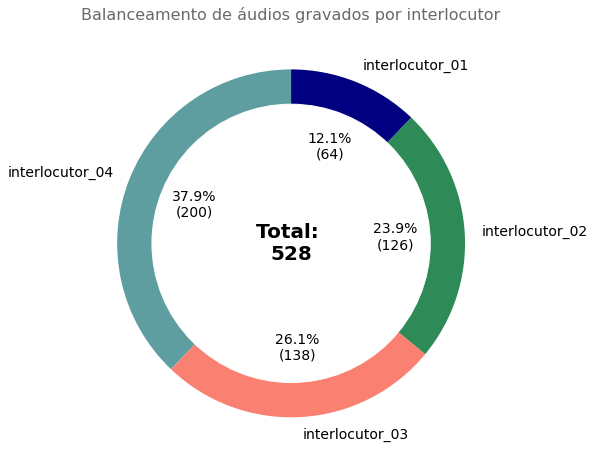

In [5]:
# Verificando volumetria entre as classes
plot_donut_chart(df=df, col='label_class', colors=DONUT_COLORS,
                 title='Balanceamento de áudios gravados por interlocutor')
print(f'Tempo total de áudio disponível: {round(df["duration"].sum()/60, 2)} minutos')

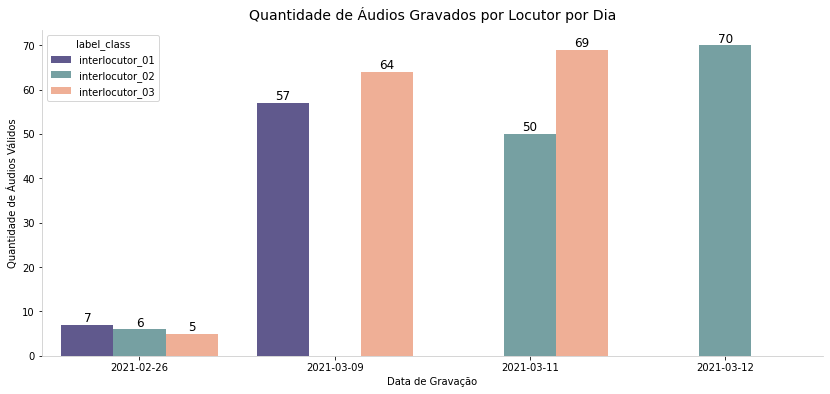

In [6]:
# Quantidade de áudios gravados por dia
df['audio_ctime'] = df['audio_path'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(os.path.getctime(x))))
df_label_filter = df.query('label_class != "interlocutor_04"')
df_audio_group = df_label_filter.groupby(by=['audio_ctime', 'label_class'], as_index=False).count().iloc[:, :3]
df_audio_group.columns = ['audio_ctime', 'label_class', 'qtd']
df_audio_group.sort_values(by='audio_ctime', inplace=True)

# Criando figura
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='audio_ctime', y='qtd', hue='label_class', data=df_audio_group, 
            palette=['darkslateblue', 'cadetblue', 'lightsalmon'], ax=ax, alpha=.9)

ax.set_xlabel('Data de Gravação')
ax.set_ylabel('Quantidade de Áudios Válidos')
ax.set_title('Quantidade de Áudios Gravados por Locutor por Dia', size=14, pad=10)
format_spines(ax=ax, right_border=False)
AnnotateBars(n_dec=0, color='black', font_size=12).vertical(ax)

plt.show()

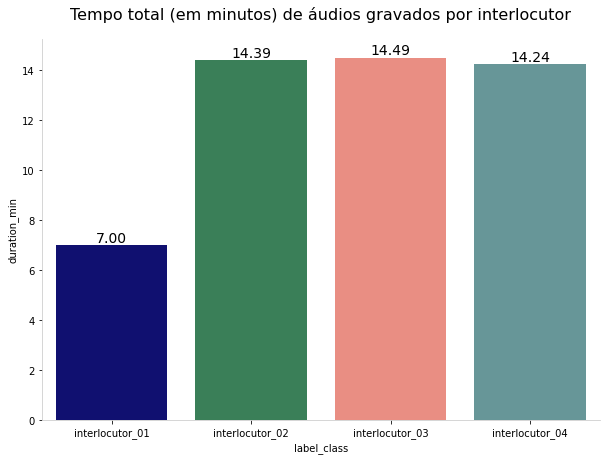

In [7]:
# Tempo total de gravação por interlocutor
df['duration_min'] = df['duration'].apply(lambda x: round(x/60, 2))
plot_aggregation(df=df, group_col='label_class', value_col='duration_min', aggreg='sum',
                 title='Tempo total (em minutos) de áudios gravados por interlocutor', 
                 palette=['navy', 'seagreen', 'salmon', 'cadetblue'])
df.drop('duration_min', axis=1, inplace=True)

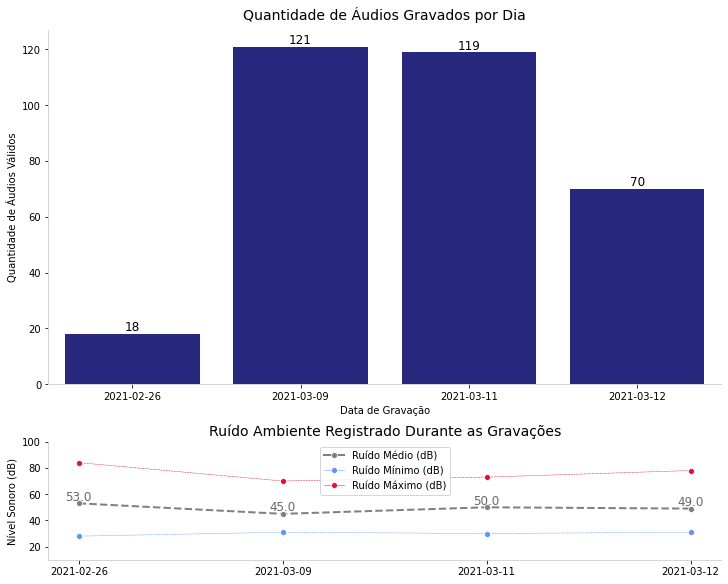

In [8]:
# Plotando cenário de gravação de áudios com ruído externo detectado
df_group = df_audio_group.groupby(by='audio_ctime', as_index=False).sum()

# Gerando dados de ruídos coletados pelo aplicativo Soundmeter
ruidos = {
    '2021-02-26': {'min': 28, 'avg': 53, 'max': 84, 'status': 'Quiet Library'},
    '2021-03-09': {'min': 31, 'avg': 45, 'max': 70, 'status': 'Quiet Park'},
    '2021-03-11': {'min': 30, 'avg': 50, 'max': 73, 'status': 'Quiet Park'},
    '2021-03-12': {'min': 31, 'avg': 49, 'max': 78, 'status': 'Quiet Park'},
}
db = pd.DataFrame(ruidos).T
db.reset_index(inplace=True)
db = db.convert_dtypes()

# Definindo figura de plotagem
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = GridSpec(nrows=4, ncols=1, figure=fig)
ax1 = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1])

# Plotando gravações por locutor por dia
sns.barplot(x='audio_ctime', y='qtd', data=df_group, color='navy', ax=ax1, alpha=.9)
ax1.set_xlabel('Data de Gravação')
ax1.set_ylabel('Quantidade de Áudios Válidos')
ax1.set_title('Quantidade de Áudios Gravados por Dia', size=14, pad=10)
format_spines(ax=ax1, right_border=False)
AnnotateBars(n_dec=0, color='black', font_size=12).vertical(ax1)

# Plotando nível de ruído
sns.lineplot(x='index', y='avg', data=db, ax=ax2, marker='o', color='gray', linewidth=2, label='Ruído Médio (dB)')
sns.lineplot(x='index', y='min', data=db, ax=ax2, marker='o', color='cornflowerblue', linewidth=.5, label='Ruído Mínimo (dB)')
sns.lineplot(x='index', y='max', data=db, ax=ax2, marker='o', color='crimson', linewidth=.5, label='Ruído Máximo (dB)')
ax2.lines[0].set_linestyle("--")
ax2.lines[1].set_linestyle("--")
ax2.lines[2].set_linestyle("--")
format_spines(ax2, right_border=False)

# Adicionando rótulos
for x, y in zip(db['index'], db['avg']):
        ax2.annotate(str(round(y/1, 2)), xy=(x, y+5), size=12,
                    textcoords='data', ha='center', va='center', color='dimgrey')
ax2.set_xlabel('')
ax2.set_ylabel('Nível Sonoro (dB)')
ax2.set_title('Ruído Ambiente Registrado Durante as Gravações', size=14)
ax2.set_ylim(10, 100)
#plt.tight_layout()
plt.show()

# Preparação e Extração de Features

Após lida a base de dados, iremos carregar o objeto `pkl` relacionado a pipeline de preparação e extração de features construído anteriormente de modo a aplicá-lo na base gerada. O pipeline contém classes transformadores para extração das seguintes características dos sinais de áudio:

* _Envelope de Amplitude_;
* _Energia Média Quadrática_;
* _Zero Crossing Rate_;
* _Taxa de Energia de Banda_;
* _Centroide Espectral_;
* _Largura de Banda_;
* _Espectrograma Agrupado_;
* _Mel-Frequency Cepstral Coefficients_

Antes de ler este objeto, é importante definir algumas funções utilizadas na preparação inicial da base, além das classes transformadores que compõem o pipeline final de preparação.

## Funções e Classes de Preparação

O bloco abaixo é responsável por definir as funções auxiliares que, juntas, fazem parte do processo inicial de preparação da base bruta de sinais. A função `data_pre_processing()` realiza a separação do sinal de áudio presente na coluna definida pela variável `SIGNAL_COL` e também da variável target definida por `TARGET_COL` (juntamente com a aplicação do encoding na variável resposta). 

As funções `calc_split_freq_bin()` e `calc_ber()` são utilizadas, respectivamente, para separação de frequências considerando a faixa discreta gerada pela STFT e para o cálculo da taxa de erro de banda (BER).

In [9]:
# Definindo função para pré processamento da base
def data_pre_processing(df, signal_col=SIGNAL_COL, target_col=TARGET_COL, encoded_target=ENCODED_TARGET):
    """
    Função responsável por filtrar as colunas utilizadas na preparação e aplicar o processo
    de encoding na variável resposta
    
    Parâmetros
    ----------
    :param df: base de dados original contendo informações de áudios [type: pd.DataFrame]
    :param signal_col: coluna de armazenamento do sinal temporal [type: string, default='signal']
    :param target_col: coluna de armazenamento da variável target [type: string, default='y_class']
    :param encoded_target: define a aplicação do encoding no array target [type: bool, default=True]
    
    Retorno
    -------
    :return X: base de dados contendo apenas o sinal de entrada dos áudios [type: pd.DataFrame]
    :return y: array multidimensional contendo informações sobre as classes [type: np.array]
    """
    
    # Filtrando dataset inicial
    X_df = df.loc[:, [signal_col]]
    y_df = df.loc[:, [target_col]]

    # Codificando variável target
    if encoded_target:
        y = pd.get_dummies(y_df[target_col]).values
    else:
        y = y_df.values.reshape(-1)

    return X_df, y

# Definindo função para separação de faixas de frequências (BER)
def calc_split_freq_bin(spec, split_freq, sr):
        """
        Função responsável por calcular o índice da frequência de separação F
        no espectro discreto de frequências

        Parâmetros
        ----------
        :param spec: espectrograma calculado via STFT [type: ndarray]
        :param split_freq: frequência de separação F [type: int]
        :param sr: taxa de amostragem do sinal [type: int]

        Retorno
        -------
        :return idx_split_freq: retorna o índice relacionado ao parâmetro F no espectro discreto [type: int]
        :return split_freq_bin: retorna a frequência discreta relacionada ao parâmetro F [type: float]
        """

        # Intervalo de frequências (Nyquist)
        f_range = sr / 2

        # Intervalo de frequências para cada faixa discreta individual
        qtd_freq_bins = spec.shape[0]
        f_delta_bin = f_range / qtd_freq_bins

        # Calculando índice do parâmetro F nas faixas discretas
        idx_split_freq = int(np.floor(split_freq / f_delta_bin))

        # Calculando faixa de frequência presente na matriz espectral
        freq_bins = np.linspace(0, f_range, qtd_freq_bins)
        split_freq_bin = freq_bins[idx_split_freq]

        return idx_split_freq, split_freq_bin

# Definindo função para o cálculo da Taxa de Energia de Banda (BER)
def calc_ber(spec, split_freq, sr):
        """
        Função responsável por calcular a taxa de energia de banda (BER)

        Parâmetros
        ----------
        :param spec: espectrograma calculado via STFT [type: ndarray]
        :param split_freq: frequência de separação F [type: int]
        :param sr: taxa de amostragem do sinal [type: int]

        Retorno
        -------
        :return ber: taxa de energia de banda para cada frame t [type: np.array]
        """

        # Calculando faixa de frequência discreta do parâmetro F
        idx_split_freq, split_freq_bin = calc_split_freq_bin(spec, split_freq, sr)
        bers = []

        # Transformando amplitudes do espectro em potências
        power_spec = np.abs(spec) ** 2

        # Aplicando transpose para iteração em cada frame
        power_spec = power_spec.T

        # Calculando somatório para cada frame
        for frame in power_spec:
            sum_power_low_freq = frame[:idx_split_freq].sum()
            sum_power_high_freq = frame[idx_split_freq:].sum()
            ber_frame = sum_power_low_freq / sum_power_high_freq
            bers.append(ber_frame)

        return np.array(bers)

O bloco de código abaixo define, de fato, os transformadores consolidados no pipeline de preparação. Isso é importante para que a biblioteca `joblib` consiga realizar a leitura do objeto `pkl` salvo. Uma alternativa a esse cenário é a consolidação dessas classes em um módulo `.py` a ser armazenado em um diretório deste projeto, sendo este importado diretamente no código como uma nova biblioteca, garantindo assim a presença de todas as classes nele definidas.

In [10]:
# Definindo transformador para envelope de amplitude
class AmplitudeEnvelop(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Retornando o envelope de amplitude para cada frame do sinal
        X['ae'] = X[self.signal_col].apply(lambda x: np.array([max(x[i:i+self.frame_size]) for i in range(0, len(x), self.hop_length)]))
        
        # Criando dicionário com agregações do envelope de amplitude de cada sinal
        X['aggreg_dict'] = X['ae'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['ae_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['ae', 'aggreg_dict'], axis=1)
            
        return X
    
# Definindo transformador para RMS Energy
class RMSEnergy(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Extraindo feature para cada sinal
        X['rms_engy'] = X[self.signal_col].apply(lambda x: librosa.feature.rms(x, frame_length=self.frame_size, 
                                                                               hop_length=self.hop_length)[0])
        
        # Criando dicionário com agregações
        X['aggreg_dict'] = X['rms_engy'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['rms_engy_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['rms_engy', 'aggreg_dict'], axis=1)
            
        return X
    
# Definindo transformador para Zero Crossing Rate
class ZeroCrossingRate(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Extraindo feature para cada sinal
        X['zcr'] = X[self.signal_col].apply(lambda x: librosa.feature.zero_crossing_rate(x, frame_length=self.frame_size, 
                                                                                         hop_length=self.hop_length)[0])
        
        # Criando dicionário com agregações
        X['aggreg_dict'] = X['zcr'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['zcr_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['zcr', 'aggreg_dict'], axis=1)
            
        return X

class BandEnergyRatio(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, split_freq, sr, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.split_freq = split_freq
        self.sr = sr
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Calculando espectrograma dos sinais
        X['spec'] = X[self.signal_col].apply(lambda x: librosa.stft(y=x, n_fft=self.frame_size, 
                                                                    hop_length=self.hop_length))
        
        # Calculando BER
        X['ber'] = X['spec'].apply(lambda x: calc_ber(spec=x, split_freq=self.split_freq, sr=self.sr))
        
        # Criando dicionário com agregações
        X['aggreg_dict'] = X['ber'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['ber_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['spec', 'ber', 'aggreg_dict'], axis=1)
            
        return X
    
# Definindo transformador para Spectral Centroid
class SpectralCentroid(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, sr, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.sr = sr
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Calculando feature
        X['sc'] = X[self.signal_col].apply(lambda x: librosa.feature.spectral_centroid(y=x, sr=self.sr,
                                                                                       n_fft=self.frame_size,
                                                                                       hop_length=self.hop_length)[0])
        
        # Criando dicionário com agregações
        X['aggreg_dict'] = X['sc'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['sc_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['sc', 'aggreg_dict'], axis=1)
            
        return X
    
# Definindo transformador para BandWidth
class BandWidth(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, sr, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.sr = sr
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Calculando feature
        X['bw'] = X[self.signal_col].apply(lambda x: librosa.feature.spectral_bandwidth(y=x, sr=self.sr,
                                                                                        n_fft=self.frame_size,
                                                                                        hop_length=self.hop_length)[0])
        
        # Criando dicionário com agregações
        X['aggreg_dict'] = X['bw'].apply(lambda x: pd.DataFrame(x).agg(self.feature_aggreg))
        
        # Extraindo agregações e enriquecendo dataset
        for agg in self.feature_aggreg:
            X['bw_' + agg] = X['aggreg_dict'].apply(lambda x: x[0][agg])
            
        # Eliminando colunas adicionais
        X = X.drop(['bw', 'aggreg_dict'], axis=1)
            
        return X
    
# Definindo transformador para agregação de espectrograma em grupos
class GroupSpecAggreg(BaseEstimator, TransformerMixin):
    
    def __init__(self, frame_size, hop_length, sr, split_freq, freq_cat_aggreg='sum',
                 signal_col='signal', feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.sr = sr
        self.split_freq = split_freq
        self.freq_cat_aggreg = freq_cat_aggreg
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Criando DataFrame vazio e aplicando STFT no sinal
        all_spec_agg = pd.DataFrame()
        X['spec'] = X[self.signal_col].apply(lambda x: np.abs(librosa.stft(y=x, n_fft=self.frame_size, 
                                                                           hop_length=self.hop_length))**2)
        
        idx_split, split_freq = calc_split_freq_bin(X['spec'][0], split_freq=self.split_freq, sr=self.sr)
        frequency_bins = np.linspace(0, self.sr/2, 1025)
        
        # Iterando sobre cada espectrograma de cada sinal
        for spec in X['spec']:
            # DataFrame intermediário para agregações de cada sinal
            signal_spec_agg = pd.DataFrame()
            i = 0
            
            # Separando frequências de acordo com threshold estabelecido
            spec_data = pd.DataFrame(spec)
            spec_data.reset_index(inplace=True)
            spec_data['freq_cat'] = spec_data['index'].apply(lambda x: 'low_freq_pwr' if x <= idx_split else 'high_freq_pwr')
            
            # Somando potências de baixas e altas frequências
            spec_data_sum = spec_data.groupby(by='freq_cat').agg(self.freq_cat_aggreg)
            spec_data_sum.drop('index', axis=1, inplace=True)
            
            # Agregando resultado agregado separado por grupo de frequências
            S_aggreg = pd.DataFrame(spec_data_sum).agg(self.feature_aggreg, axis=1)
            #print(spec_data_sum)
            #print(S_aggreg)

            # Iterando sobre cada agregador para gerar um novo DataFrame
            for agg in self.feature_aggreg:
                S_agg = pd.DataFrame(S_aggreg[agg]).T
                S_agg.reset_index(inplace=True, drop=True)
                S_agg.columns = [col + '_' + agg for col in S_agg.columns]
                
                # Unindo agregadores em DataFrame intermediário do sinal
                if i == 0:
                    signal_spec_agg = S_agg.copy()
                else:
                    signal_spec_agg = signal_spec_agg.merge(S_agg, left_index=True, right_index=True)
                i += 1
            
            # Empilhando compilado agregado de cada sinal
            all_spec_agg = all_spec_agg.append(signal_spec_agg)
        
        # Enriquecendo dataset com agregações geradas
        all_spec_agg.reset_index(inplace=True, drop=True)
        X = X.merge(all_spec_agg, left_index=True, right_index=True)
        
        # Dropando colunas auxiliares
        X.drop('spec', axis=1, inplace=True)
        
        return X
    
# Definindo transformador para agregação individual de espectrograma
class MFCCsAggreg(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_mfcc, order=0, signal_col='signal',
                 feature_aggreg=['mean', 'median', 'std', 'var', 'max', 'min']):
        self.n_mfcc = n_mfcc
        self.order = order
        self.signal_col = signal_col
        self.feature_aggreg = feature_aggreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Criando DataFrame vazio e retornando mfccs
        all_mfcc_agg = pd.DataFrame()
        X['mfcc'] = X[self.signal_col].apply(lambda x: librosa.feature.mfcc(y=x, n_mfcc=self.n_mfcc))
        
        # Calculando derivadas (se aplicáveis)
        if self.order == 1:
            X['d1_mfcc'] = X['mfcc'].apply(lambda x: librosa.feature.delta(x, order=1))
        
        if self.order == 2:
            X['d1_mfcc'] = X['mfcc'].apply(lambda x: librosa.feature.delta(x, order=1))
            X['d2_mfcc'] = X['mfcc'].apply(lambda x: librosa.feature.delta(x, order=2))
        
        # Iterando sobre cada conjunto de coeficientes mfccs de cada sinal
        if self.order == 0:
            for mfcc in X['mfcc']:
                # DataFrame intermediário para agregações de cada sinal
                signal_mfcc_agg = pd.DataFrame()
                i = 0

                # Agregando dimensão temporal do espectrograma (eixo 1)
                M_aggreg = pd.DataFrame(mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg.index = ['mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]

                # Iterando sobre cada agregador para gerar um novo DataFrame
                for agg in self.feature_aggreg:
                    M_agg = pd.DataFrame(M_aggreg[agg]).T
                    M_agg.reset_index(inplace=True, drop=True)
                    M_agg.columns = [col + '_' + agg for col in M_agg.columns]

                    # Unindo agregadores em DataFrame intermediário do sinal
                    if i == 0:
                        signal_mfcc_agg = M_agg.copy()
                    else:
                        signal_mfcc_agg = signal_mfcc_agg.merge(M_agg, left_index=True, right_index=True)
                    i += 1

                # Empilhando compilado agregado de cada sinal
                all_mfcc_agg = all_mfcc_agg.append(signal_mfcc_agg)
                to_drop = ['mfcc']
                
        elif self.order == 1:
            for mfcc, d1_mfcc in X.loc[:, ['mfcc', 'd1_mfcc']].values:
                # DataFrame intermediário para agregações de cada sinal
                signal_mfcc_agg = pd.DataFrame()
                i = 0

                # Agregando dimensão temporal do espectrograma (eixo 1)
                M_aggreg_d0 = pd.DataFrame(mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg_d0.index = ['mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]
                
                M_aggreg_d1 = pd.DataFrame(d1_mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg_d1.index = ['d1_mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]

                # Iterando sobre cada agregador para gerar um novo DataFrame
                for agg in self.feature_aggreg:
                    M_agg_d0 = pd.DataFrame(M_aggreg_d0[agg]).T
                    M_agg_d0.reset_index(inplace=True, drop=True)
                    M_agg_d0.columns = [col + '_' + agg for col in M_agg_d0.columns]
                                       
                    M_agg_d1 = pd.DataFrame(M_aggreg_d1[agg]).T
                    M_agg_d1.reset_index(inplace=True, drop=True)
                    M_agg_d1.columns = [col + '_' + agg for col in M_agg_d1.columns]
                    
                    M_agg = M_agg_d0.merge(M_agg_d1, left_index=True, right_index=True)

                    # Unindo agregadores em DataFrame intermediário do sinal
                    if i == 0:
                        signal_mfcc_agg = M_agg.copy()
                    else:
                        signal_mfcc_agg = signal_mfcc_agg.merge(M_agg, left_index=True, right_index=True)
                    i += 1

                # Empilhando compilado agregado de cada sinal
                all_mfcc_agg = all_mfcc_agg.append(signal_mfcc_agg)
                to_drop = ['mfcc', 'd1_mfcc']
                
        elif self.order == 2:
            for mfcc, d1_mfcc, d2_mfcc in X.loc[:, ['mfcc', 'd1_mfcc', 'd2_mfcc']].values:
                # DataFrame intermediário para agregações de cada sinal
                signal_mfcc_agg = pd.DataFrame()
                i = 0

                # Agregando dimensão temporal do espectrograma (eixo 1)
                M_aggreg_d0 = pd.DataFrame(mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg_d0.index = ['mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]
                
                M_aggreg_d1 = pd.DataFrame(d1_mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg_d1.index = ['d1_mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]
                
                M_aggreg_d2 = pd.DataFrame(d2_mfcc).agg(self.feature_aggreg, axis=1)
                M_aggreg_d2.index = ['d2_mfcc_c' + str(i) for i in range(1, self.n_mfcc + 1)]

                # Iterando sobre cada agregador para gerar um novo DataFrame
                for agg in self.feature_aggreg:
                    M_agg_d0 = pd.DataFrame(M_aggreg_d0[agg]).T
                    M_agg_d0.reset_index(inplace=True, drop=True)
                    M_agg_d0.columns = [col + '_' + agg for col in M_agg_d0.columns]
                                       
                    M_agg_d1 = pd.DataFrame(M_aggreg_d1[agg]).T
                    M_agg_d1.reset_index(inplace=True, drop=True)
                    M_agg_d1.columns = [col + '_' + agg for col in M_agg_d1.columns]
                    
                    M_agg_d2 = pd.DataFrame(M_aggreg_d2[agg]).T
                    M_agg_d2.reset_index(inplace=True, drop=True)
                    M_agg_d2.columns = [col + '_' + agg for col in M_agg_d2.columns]
                    
                    M_agg = M_agg_d0.merge(M_agg_d1, left_index=True, right_index=True)
                    M_agg = M_agg.merge(M_agg_d2, left_index=True, right_index=True)

                    # Unindo agregadores em DataFrame intermediário do sinal
                    if i == 0:
                        signal_mfcc_agg = M_agg.copy()
                    else:
                        signal_mfcc_agg = signal_mfcc_agg.merge(M_agg, left_index=True, right_index=True)
                    i += 1

                # Empilhando compilado agregado de cada sinal
                all_mfcc_agg = all_mfcc_agg.append(signal_mfcc_agg)
                to_drop = ['mfcc', 'd1_mfcc', 'd2_mfcc']
        
        # Enriquecendo dataset com agregações geradas
        all_mfcc_agg.reset_index(inplace=True, drop=True)
        X = X.merge(all_mfcc_agg, left_index=True, right_index=True)
        
        # Dropando colunas auxiliares
        X.drop(to_drop, axis=1, inplace=True)
        
        return X

## Preparação da Base

Assim, garantindo as definições de funções e classes auxiliares, é possível aplicar as devidas preparações e extrações de features do sinal considernado, como entrada, a base bruta lida e armazenada no objeto DataFrame `df`. Espera-se do resultado a construção das bases `X` e `y` prontas (ou praticamente prontas) para serem utilizadas em processos de modelagem de dados.

In [11]:
# Preparação inicial da base
X, y = data_pre_processing(df=df, signal_col=SIGNAL_COL, target_col=TARGET_COL, 
                           encoded_target=ENCODED_TARGET)

# Leitura do pipeline
audio_fe_pipeline = joblib.load(os.path.join(PIPELINES_PATH, PIPELINE_NAME))

# Aplicação do pipeline
X_prep = audio_fe_pipeline.fit_transform(X)
X_prep.drop('signal', axis=1, inplace=True)
print(f'Dimensões da base final resultante: {X_prep.shape}')

# Armazenando features
FEATURES = list(X_prep.columns)
X_prep.head()

Dimensões da base final resultante: (528, 329)


,ae_mean,ae_median,ae_std,ae_var,ae_max,ae_kurtosis,ae_skew,rms_engy_mean,rms_engy_median,rms_engy_std,...,d2_mfcc_c4_skew,d2_mfcc_c5_skew,d2_mfcc_c6_skew,d2_mfcc_c7_skew,d2_mfcc_c8_skew,d2_mfcc_c9_skew,d2_mfcc_c10_skew,d2_mfcc_c11_skew,d2_mfcc_c12_skew,d2_mfcc_c13_skew
0,0.026926,0.024551,0.025405,0.000645,0.100281,-0.407265,0.657465,0.010282,0.006725,0.010507,...,-0.095536,0.000196,-0.032682,-0.065811,0.247216,-0.127826,0.002358,-0.011661,-0.126005,-0.255435
1,0.028720,0.021637,0.023985,0.000575,0.082886,-0.722284,0.601592,0.009458,0.006850,0.008471,...,-0.178079,0.252923,0.044729,-0.386802,0.298031,0.277980,0.123586,0.266878,0.002533,-0.085121
2,0.028412,0.018982,0.029994,0.000900,0.117493,0.216276,1.022808,0.008077,0.004316,0.009053,...,0.113913,0.513224,0.331324,-0.086623,-0.335730,-0.056135,0.123269,-0.392528,-0.140838,-0.014162
3,0.035016,0.030731,0.026640,0.000710,0.115021,0.366818,0.853834,0.011825,0.010346,0.009402,...,-0.349900,0.329761,0.025554,-0.061863,0.054441,0.198784,0.156727,0.220597,-0.187746,-0.082708
4,0.046102,0.038208,0.043858,0.001923,0.208038,1.570043,1.269211,0.014332,0.010886,0.014519,...,0.025121,0.003083,-0.023941,-0.179321,-0.012903,0.168405,-0.082846,0.282288,-0.304904,-0.022267


# Modelagem

Nessa sessão, serão consideradas as etapas necessárias para o treinamento e avaliação de classificadores capazes de identificar os locutores a partir das features extraídas de sinais de áudio. Neste cenário, será utilizada a biblioteca [pycomp](https://github.com/ThiagoPanini/pycomp), de desenvolvimento próprio, para facilitar todas as etapas atreladas ao aprendizado de máquina.

<img src="https://i.imgur.com/WcAaq1P.png" alt="pycomp Logo">

## Train, Dev e Teste

A etapa de modelagem tem início a partir da separação da base de dados preparada em três conjuntos distintos: treino, validação e teste. A proporção considerada para essa separação leva em conta o conteúdo das variáveis `TRAIN_RATIO`, `VAL_RATIO` e `TEST_RATIO` em uma proporção 75%, 15% e 10%, respectivamente.

In [12]:
# Gerando bases de treino, validação e teste 
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=1-TRAIN_RATIO, 
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=TEST_RATIO/(TEST_RATIO+VAL_RATIO), 
                                                random_state=42)

# Verificando dimensões
print(f'Dimensões de X_train: {X_train.shape} - {round(100 * (X_train.shape[0] / len(df)), 2)}% do total')
print(f'Dimensões de X_val: {X_val.shape} - {round(100 * (X_val.shape[0] / len(df)), 2)}% do total')
print(f'Dimensões de X_test: {X_test.shape} - {round(100 * (X_test.shape[0] / len(df)), 2)}% do total')

Dimensões de X_train: (396, 329) - 75.0% do total
Dimensões de X_val: (79, 329) - 14.96% do total
Dimensões de X_test: (53, 329) - 10.04% do total


## Definições Iniciais

Como primeiro passo, de acordo com as recomendações e os requisitos da biblioteca `pycomp`, serão definidos os elementos necessários para utilização das funcionalidades exigidas pelo pacote, como por exemplo, a importação dos modelos e a construção de estruturas pré definidas envolvendo os objetos de entrada da análise preditiva.

In [13]:
# Importando modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Instanciando objetos
dtree = DecisionTreeClassifier()
forest = RandomForestClassifier()
lgbm = LGBMClassifier(objective='multiclass', num_class=4)

# Criando dicionário set_classifiers
model_obj = [dtree, forest, lgbm]
model_names = [type(model).__name__ for model in model_obj]
set_classifiers = {name: {'model': obj, 'params': {}} for (name, obj) in zip(model_names, model_obj)}

print(f'Classificadores a serem treinados e avaliados: \n\n{model_names}')

Classificadores a serem treinados e avaliados: 

['DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier']


## Treinamento de Modelos

Uma vez preparada a estrutura de modelagem a partir de objetos específicos, como por exemplo, o dicionário `set_classifiers`, é possível agora importar a classe `ClassificadorMulticlasse` presente no módulo `pycomp.ml.trainer` para realizar todo o treinamento e avaliação dos modelos candidatos.

Essa classe foi desenvolvida com o intuito de facilitar grandemente o trabalho do analista/cientista em termos de implementação de códigos para treinar, avaliar e otimizar modelos preditivos de classificação binária. Seus métodos comportam poderosas funcionalidades que realizam diversas ações com apenas uma chamada.

In [14]:
# Instanciando objeto e treinando modelos
trainer = ClassificadorMulticlasse(encoded_target=ENCODED_TARGET)
trainer.fit(set_classifiers, X_train, y_train, random_search=False)

DEBUG;2021-03-26 23:29:03;trainer.py;trainer;1606;Treinando modelo DecisionTreeClassifier
DEBUG;2021-03-26 23:29:03;trainer.py;trainer;1606;Treinando modelo RandomForestClassifier
DEBUG;2021-03-26 23:29:04;trainer.py;trainer;1606;Treinando modelo LGBMClassifier


O método `fit()` do objeto `trainer` criado tem a responsabilidade de realizar o treinamento dos modelos encapsulados no dicionário `set_classifiers` criado na etapa de definições iniciais.

Configurando o método para aplicar também o processo de `RandomizedSearchCV` (busca aleatória dos melhores hiperparâmetros de cada algoritmo), é possível construir modelos otimizados de acordo com o espaço de busca passado no dicionário `set_classifiers`.

## Avaliando Performance

Uma vez treinados os modelos candidatos para reconhecimento de locutores através do método `fit()`, é possível então avaliar a performance obtida em cada um dos casos, retornando assim as principais métricas de classificação capazes de nos indicar o melhor direcionamento para a dada tarefa.

Para realizar esse processo, podemos utilizar os métodos `evaluate_performance()` do objeto `trainer`, gerando assim um DataFrame analítico contendo o resultado da avaliação de cada modelo frente as principais métricas.

In [15]:
# Avaliando performance
metrics = trainer.evaluate_performance(X_train, y_train, X_val, y_val, target_names=TARGET_NAMES)
metrics

DEBUG;2021-03-26 23:29:05;trainer.py;trainer;1679;Computando métricas do modelo DecisionTreeClassifier utilizando validação cruzada com 5 K-folds
INFO;2021-03-26 23:29:05;trainer.py;trainer;1712;Métricas computadas com sucesso nos dados de treino em 0.177 segundos
DEBUG;2021-03-26 23:29:05;trainer.py;trainer;1746;Computando métricas do modelo DecisionTreeClassifier utilizando dados de teste
INFO;2021-03-26 23:29:05;trainer.py;trainer;1779;Métricas computadas com sucesso nos dados de validação em 0.012 segundos
DEBUG;2021-03-26 23:29:05;trainer.py;trainer;1679;Computando métricas do modelo RandomForestClassifier utilizando validação cruzada com 5 K-folds
INFO;2021-03-26 23:29:07;trainer.py;trainer;1712;Métricas computadas com sucesso nos dados de treino em 1.139 segundos
DEBUG;2021-03-26 23:29:07;trainer.py;trainer;1746;Computando métricas do modelo RandomForestClassifier utilizando dados de teste
INFO;2021-03-26 23:29:07;trainer.py;trainer;1779;Métricas computadas com sucesso nos dados

,model,approach,class,accuracy,precision,recall,f1-score,total_time,anomesdia_datetime
0,DecisionTreeClassifier,Treino 5 K-folds,Locutor 01,0.952020,0.891304,0.872340,0.881720,0.177,2021-03-26 23:29:13.151895
1,DecisionTreeClassifier,Treino 5 K-folds,Locutor 02,0.952020,0.958763,0.930000,0.944162,0.177,2021-03-26 23:29:13.151895
2,DecisionTreeClassifier,Treino 5 K-folds,Locutor 03,0.952020,0.941176,0.960000,0.950495,0.177,2021-03-26 23:29:13.151895
3,DecisionTreeClassifier,Treino 5 K-folds,Locutor 04,0.952020,0.973510,0.986577,0.980000,0.177,2021-03-26 23:29:13.151895
0,DecisionTreeClassifier,Validation set,Locutor 01,0.974684,1.000000,0.909091,0.952381,0.012,2021-03-26 23:29:13.151895
1,DecisionTreeClassifier,Validation set,Locutor 02,0.974684,0.888889,1.000000,0.941176,0.012,2021-03-26 23:29:13.151895
2,DecisionTreeClassifier,Validation set,Locutor 03,0.974684,1.000000,0.954545,0.976744,0.012,2021-03-26 23:29:13.151895
3,DecisionTreeClassifier,Validation set,Locutor 04,0.974684,1.000000,1.000000,1.000000,0.012,2021-03-26 23:29:13.151895
0,RandomForestClassifier,Treino 5 K-folds,Locutor 01,0.992424,0.959184,1.000000,0.979167,1.139,2021-03-26 23:29:13.151895
1,RandomForestClassifier,Treino 5 K-folds,Locutor 02,0.992424,1.000000,0.990000,0.994975,1.139,2021-03-26 23:29:13.151895


Adicionalmente, o método `plot_metrics()` do objeto `trainer` pode ser utilizado para uma visualização gráfica da performance dos modelos treinados (colunas) em diferentes abordagens (linhas). Dessa forma, é possível analisar de forma mais intuitiva qual o melhor algoritmo para a tarefa de reconhecimento de locutores a partir da voz, seja na base de treino (utilizando validação cruzada) ou na base de validação.

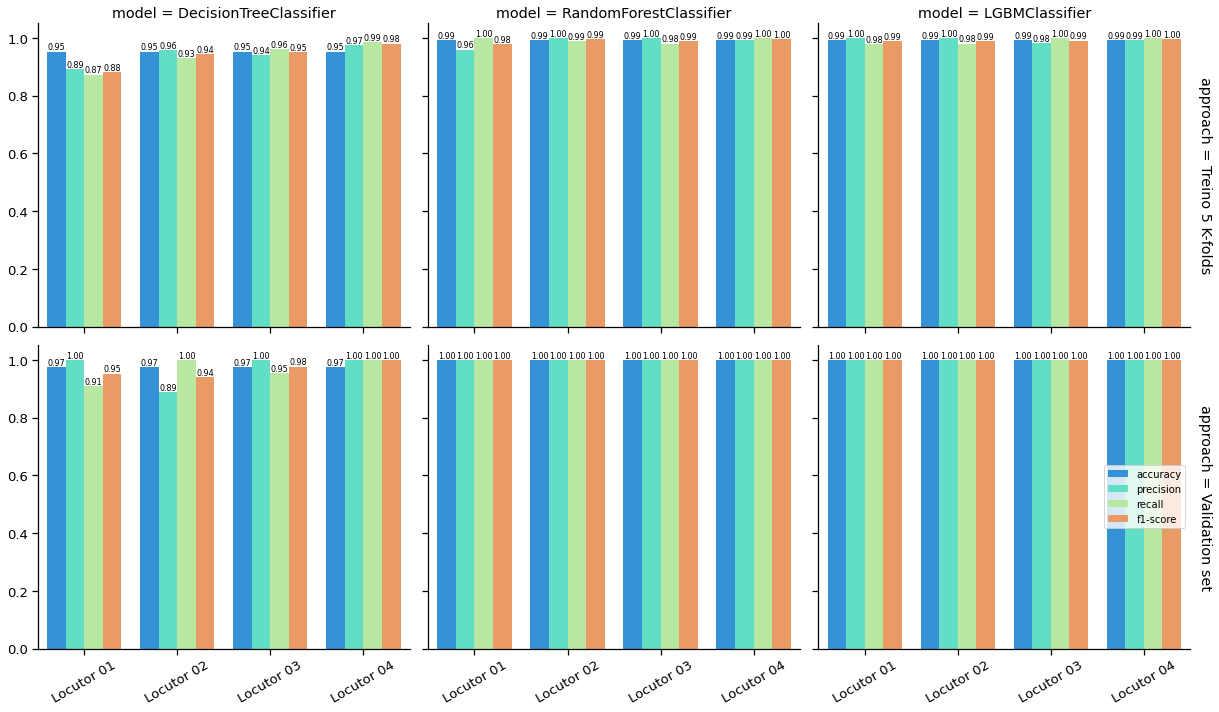

In [16]:
# Plotando métricas
trainer.plot_metrics(df_metrics=metrics)

DEBUG;2021-03-26 23:29:14;trainer.py;trainer;2021;Inicializando plotagem da matriz de confusão para os modelos
DEBUG;2021-03-26 23:29:14;trainer.py;trainer;2029;Retornando dados de treino e validação para o modelo DecisionTreeClassifier
DEBUG;2021-03-26 23:29:14;trainer.py;trainer;2046;Realizando predições para os dados de treino e validação (DecisionTreeClassifier)
DEBUG;2021-03-26 23:29:14;trainer.py;trainer;2054;Gerando matriz de confusão para o modelo DecisionTreeClassifier
INFO;2021-03-26 23:29:15;trainer.py;trainer;2067;Matriz de confusão gerada para o modelo DecisionTreeClassifier
DEBUG;2021-03-26 23:29:15;trainer.py;trainer;2029;Retornando dados de treino e validação para o modelo RandomForestClassifier
DEBUG;2021-03-26 23:29:15;trainer.py;trainer;2046;Realizando predições para os dados de treino e validação (RandomForestClassifier)
DEBUG;2021-03-26 23:29:16;trainer.py;trainer;2054;Gerando matriz de confusão para o modelo RandomForestClassifier
INFO;2021-03-26 23:29:16;trainer.

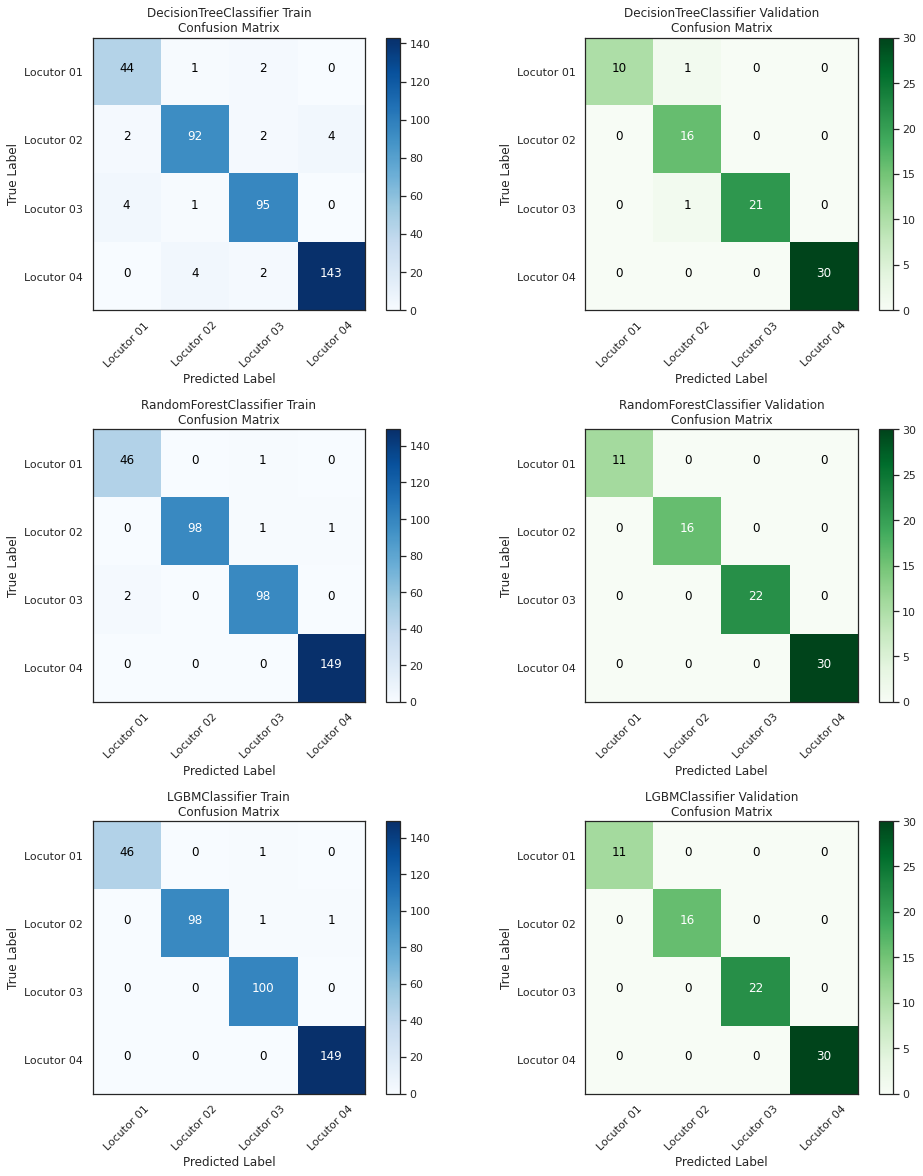

In [17]:
# Plotando matriz de confusão
trainer.plot_confusion_matrix(classes=TARGET_NAMES)

DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2101;Inicializando plotagem das features mais importantes para os modelos
DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2112;Extraindo importância das features para o modelo DecisionTreeClassifier
DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2125;Plotando gráfico de importância das features para o modelo DecisionTreeClassifier
INFO;2021-03-26 23:29:22;trainer.py;trainer;2136;Gráfico de importância das features plotado com sucesso para o modelo DecisionTreeClassifier
DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2112;Extraindo importância das features para o modelo RandomForestClassifier
DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2125;Plotando gráfico de importância das features para o modelo RandomForestClassifier
INFO;2021-03-26 23:29:22;trainer.py;trainer;2136;Gráfico de importância das features plotado com sucesso para o modelo RandomForestClassifier
DEBUG;2021-03-26 23:29:22;trainer.py;trainer;2112;Extraindo importância das features para

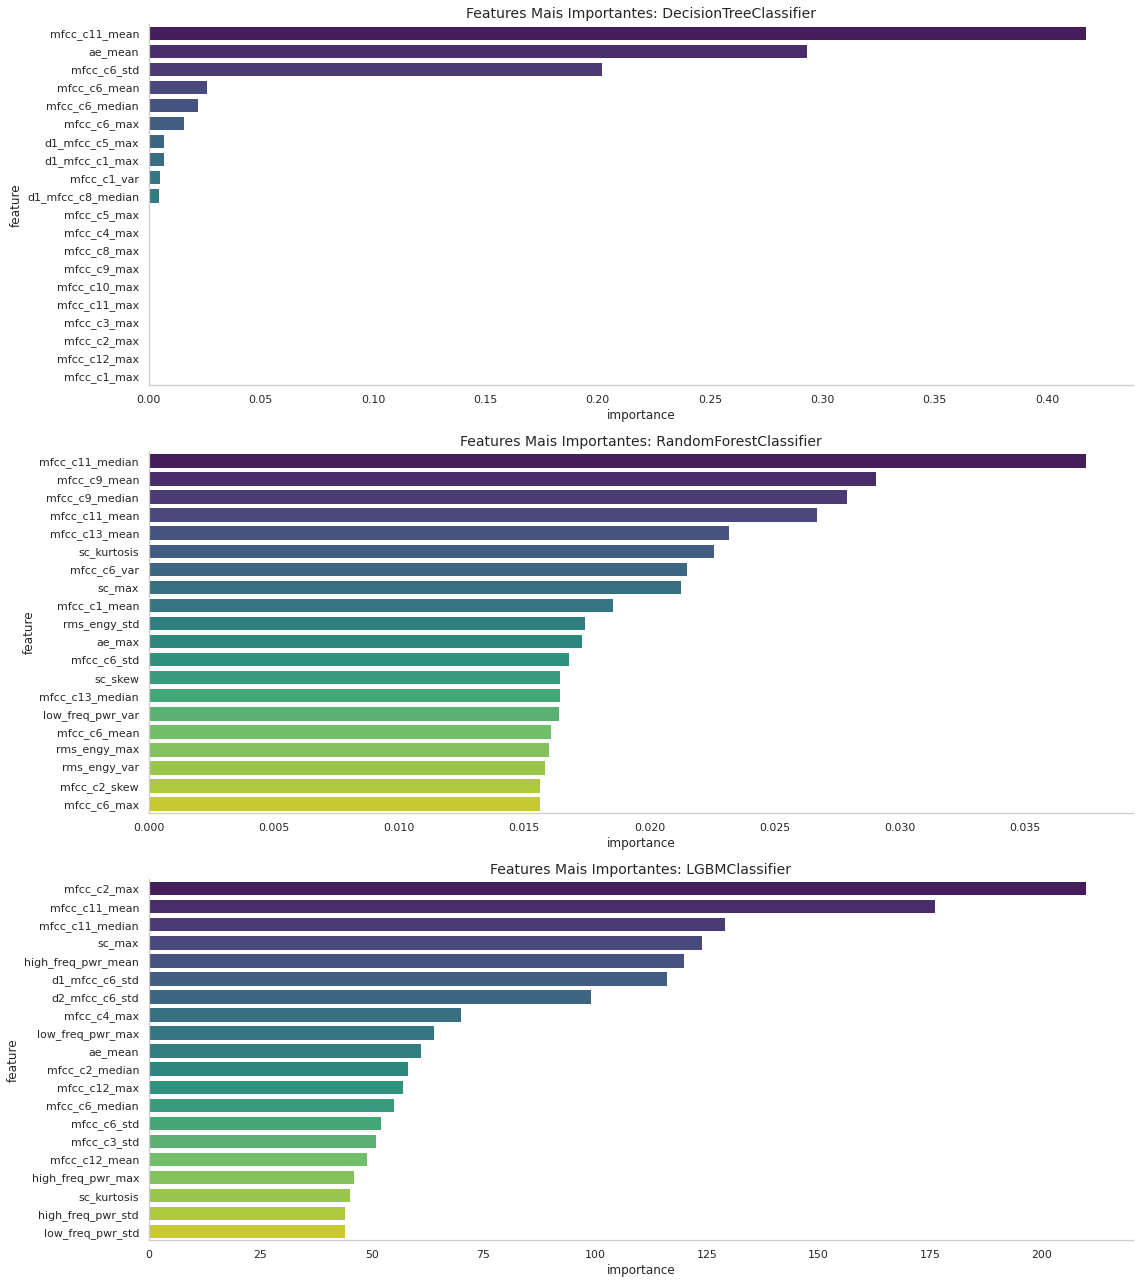

In [18]:
# Plotando importância das features
trainer.plot_feature_importance(features=FEATURES)

DEBUG;2021-03-26 23:30:16;trainer.py;trainer;2181;Explicando o modelo RandomForestClassifier através da análise shap
DEBUG;2021-03-26 23:30:16;trainer.py;trainer;2189;Retornando parâmetros da classe para o modelo RandomForestClassifier
DEBUG;2021-03-26 23:30:16;trainer.py;trainer;2199;Criando explainer e gerando valores shap para o modelo RandomForestClassifier
DEBUG;2021-03-26 23:30:17;trainer.py;trainer;2219;Plotando análise shap para o modelo RandomForestClassifier


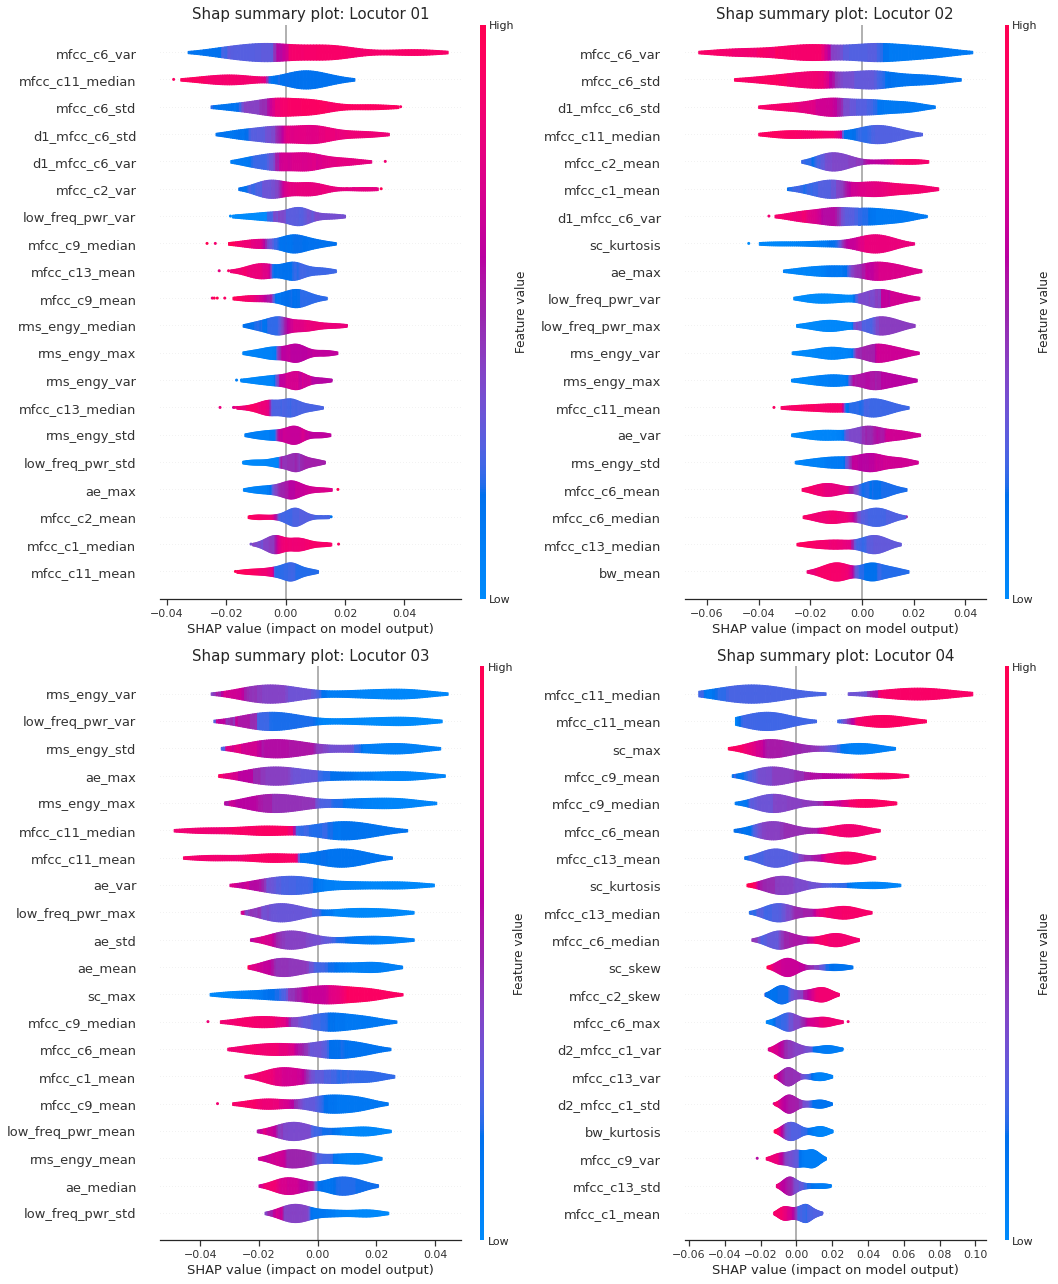

In [22]:
# Plotando análise shap
trainer.plot_shap_analysis(model_name='RandomForestClassifier', features=FEATURES, n_classes=N_CLASSES,
                           target_names=TARGET_NAMES)

___

In [20]:
# Testando amostra
test_sample = X_test.iloc[:10, :]
target_sample = y_test[:10]

# Retornando modelo
dtree = trainer.get_estimator(model_name='LGBMClassifier')

# Identificando locutor
y_pred = dtree.predict(test_sample)
print(f'Resultado real esperado: \n{target_sample}')
print(f'\nResultado do modelo: \n{y_pred}')

DEBUG;2021-03-26 23:29:40;trainer.py;trainer;2250;Retornando estimator do modelo LGBMClassifier já treinado


Resultado real esperado: 
[1 4 3 3 4 4 1 4 1 4]

Resultado do modelo: 
[1 4 3 3 4 4 1 4 1 4]


In [21]:
# Testando com bases .ogg utilizadas nas primeiras análises
SAMPLES_PATH = os.path.join(DATA_PATH, 'samples')
samples_files = [file for file in os.listdir(SAMPLES_PATH) if '.ogg' in file]

# Lendo e preparando áudios
samples = [librosa.load(os.path.join(SAMPLES_PATH, samples_files[i]))[0] for i in range(3)]
df_ogg = pd.DataFrame({})
df_ogg['signal'] = samples
y_sample = np.array([1, 2, 3])

# Executando pipeline
X_ogg = audio_fe_pipeline.fit_transform(df_ogg)
X_ogg = X_ogg.iloc[:, 1:]
print(f'Esperado: {y_sample}')
print(f'Predição: {dtree.predict(X_ogg)}')

Esperado: [1 2 3]
Predição: [2 2 4]
